In [1]:
import math
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import breathDetectionFunctions as bd   
% matplotlib inline

In [2]:
# read in dataset
dset = pd.read_csv('Speed 4 - 3_3_2017 15_55_14.txt',sep = ' ') # read in dataset

In [3]:
#Variables
f=10

print("Sampling rate: " + str(f) + "Hz")
print(str(dset.shape[0]) + " Data points")
print(str(dset.shape[0]/(f*60)) + " Minutes")

Sampling rate: 10Hz
2909 Data points
4.848333333333334 Minutes


In [4]:
# pick subsample (just for visualization purposes, so I am not plotting the whole dataset each time.)
d = pd.DataFrame(data = dset[0:dset.shape[0]]) #Picking all the data
#d = pd.DataFrame(data = dset[85670:96060]) #Select which data points; used to be [:8000]
d.index = pd.RangeIndex(start = 0, stop = len(d), step = 1) # to measure time from beginning of sub-sample
d.columns = ['chest','belly','ax','ay','az','gx','gy','gz']
d['time'] = d.index*(1/f) # add timestamp assuming 10 samples / second

d = d.reset_index()

# smoothen sample: subsecond dynamics are removed using exponentially weighted moving average
d['cesm'] = d['chest'].rolling(window = 100,center = False).apply(lambda x: bd.expSmoothen(x,f)) # smoothen
#d['besm'] = d['belly'].rolling(window = 100,center = False).apply(lambda x: bd.expSmoothen(x,f)) # smoothen

# calculate [6] second moving average and subtract it from smoothened signal to remove long-term drift 
d['cmav'] = d['chest'].rolling(window = 7*f,center = False).mean() - 0 # slight offset because breaths are held for some time.
d['del'] = d['cesm'] - d['cmav']

# calculate [6] second moving average and subtract it from smoothened signal to remove long-term drift 
#d['bmav'] = d['belly'].rolling(window = 7*f,center = False).mean() - 0 # slight offset because breaths are held for some time.
#d['bdel'] = d['besm'] - d['bmav']

# identify breath phase: distinguishes between above-average and below-average expansion of the sensor. 
d['ph1'] = d['del'].apply(bd.phase) # function: +1 if positive, -1 if negative
#d['ph2'] = d['bdel'].apply(bd.phase) # function: +1 if positive, -1 if negative

# take derivative of phase curve: +1 where rise, -1 where fall
d['ph1_slp'] = 0.025*d['ph1'].rolling(window = 2, center = False).apply(bd.slp)
#d['ph2_slp'] = 0.025*d['ph2'].rolling(window = 2, center = False).apply(bd.slp)

# store vector with the last [-x:] rise times,
d['riseTimes'] = d['time'].apply(lambda x: d['time'][0:int(x/(1/f))][d['ph1_slp'][0:int(x/(1/f))]>0].values[-10:])
#d['briseTimes'] = d['time'].apply(lambda x: d['time'][0:int(x/(1/f))][d['ph2_slp'][0:int(x/(1/f))]>0].values[-10:])

# store vector with the last [-x:] fall times
d['fallTimes'] = d['time'].apply(lambda x: d['time'][0:int(x/(1/f))][d['ph1_slp'][0:int(x/(1/f))]<0].values[-10:])
#d['bfallTimes'] = d['time'].apply(lambda x: d['time'][0:int(x/(1/f))][d['ph2_slp'][0:int(x/(1/f))]<0].values[-10:])

# calculate last [19] breath times based on rise times
d['rbtime'] = d['riseTimes'].apply(lambda x: x[1:] - x[:-1])
# calculate last [19] breath times based on fall times
d['fbtime'] = d['fallTimes'].apply(lambda x: x[1:] - x[:-1])
# calculate last [19] breath times based on rise times
#d['brbtime'] = d['briseTimes'].apply(lambda x: x[1:] - x[:-1])
# calculate last [19] breath times based on fall times
#d['bfbtime'] = d['bfallTimes'].apply(lambda x: x[1:] - x[:-1])

# replace empty entries with NaN
def repNan(x):
    if len(x) == 0:
        return [np.nan]
    else:
        return x
    
# filter all breath measurements that are unrealistically short or long
def filterBreaths(x):
    return [d for d in x if d > 1.5 and d < 24]
    
d['rbtime'] = d['rbtime'].apply(lambda x: filterBreaths(x)).apply(repNan)
d['fbtime'] = d['fbtime'].apply(lambda x: filterBreaths(x)).apply(repNan)
#d['brbtime'] = d['brbtime'].apply(lambda x: filterBreaths(x)).apply(repNan)
#d['bfbtime'] = d['bfbtime'].apply(lambda x: filterBreaths(x)).apply(repNan)

#def lastEntry(x):
#    if len(x) > 0:
#        return x[-1]
#    else:
#        return np.nan
    
d['rlast'] = d['rbtime'].apply(lambda x: x[-1])
d['flast'] = d['fbtime'].apply(lambda x: x[-1])
#d['brlast'] = d['brbtime'].apply(lambda x: x[-1])
#d['bflast'] = d['bfbtime'].apply(lambda x: x[-1])

# calculate averaged breath time 
d['rmav'] = d['rlast'].rolling(window = 30*f, center = False).mean().apply(lambda x: 60/x)
d['fmav'] = d['flast'].rolling(window = 30*f, center = False).mean().apply(lambda x: 60/x) # calculate 30s average breath rate
d['rfmav'] = (d['rmav']+ d['fmav'])/2

#d['brmav'] = d['brlast'].rolling(window = 30*f, center = False).mean().apply(lambda x: 60/x)
#d['bfmav'] = d['bflast'].rolling(window = 30*f, center = False).mean().apply(lambda x: 60/x) # calculate 30s average breath rate
#d['brfmav'] = (d['brmav']+ d['bfmav'])/2

# movement data acceleration
d['acc'] = (d['ax'].multiply(d['ax']) + d['ay'].multiply(d['ay']) + d['az'].multiply(d['az'])).apply(np.sqrt)

# movement data angular velocity
d['gyr'] = (d['gx'].multiply(d['gx']) + d['gy'].multiply(d['gy']) + d['gz'].multiply(d['gz'])).apply(np.sqrt)

Autonomic: 0.0 minutes
Autonomic light: 1.96833333333 minutes
Normal breathing: 1.75166666667 minutes
Cardio: 0.306666666667 minutes
Total: 4.02666666667 minutes


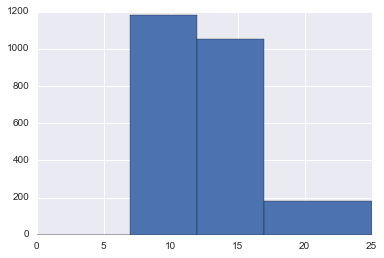

In [5]:
#Calculate the occurrence of each breathing type
occurrence=d['rfmav'].hist(bins=[0,7,12,17,25])
def get_hist(ax):
    n=[]
    for rect in ax.patches:
        ((x0, y0), (x1, y1)) = rect.get_bbox().get_points()
        n.append(y1-y0)
    return n
n = get_hist(occurrence)

b1=n[0]/(60*f)
b2=n[1]/(60*f)
b3=n[2]/(60*f)
b4=n[3]/(60*f)

print("Autonomic: " + str(b1) + " minutes")
print("Autonomic light: " + str(b2) + " minutes")
print("Normal breathing: " + str(b3) + " minutes")
print("Cardio: " + str(b4) + " minutes")
print("Total: " + str(b1+b2+b3+b4) + " minutes")

In [6]:
f=d

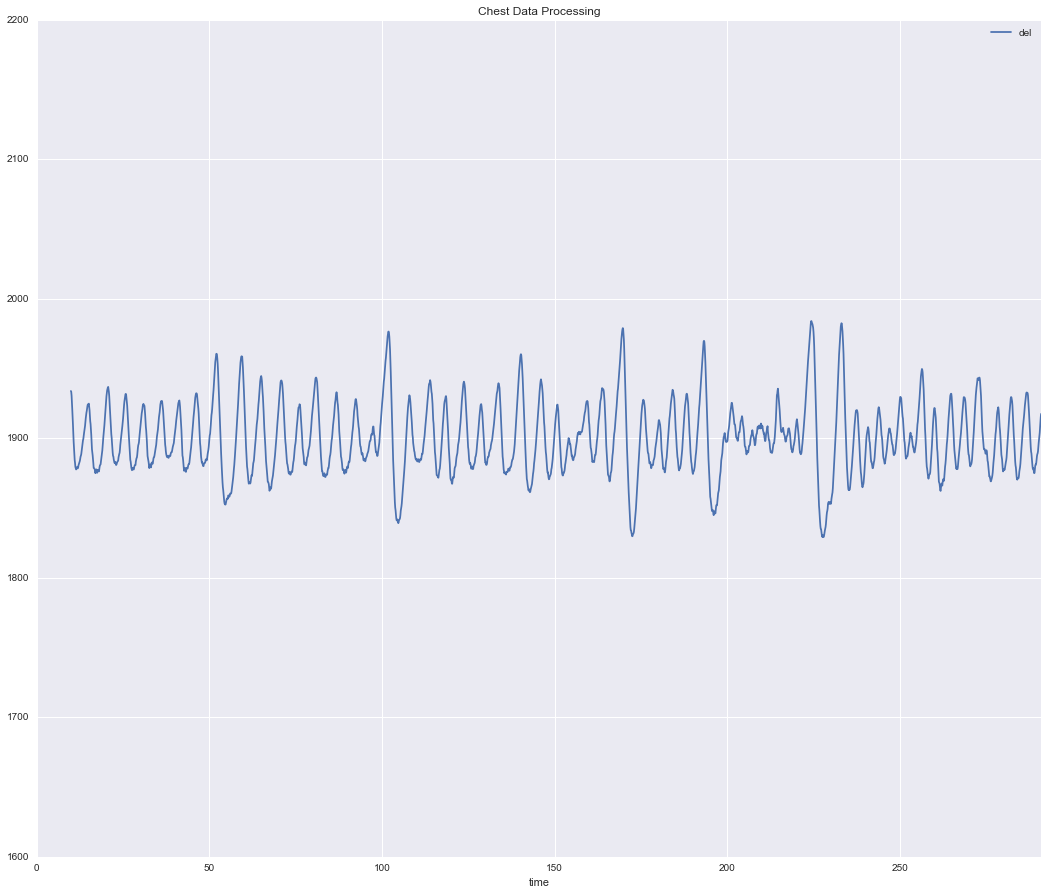

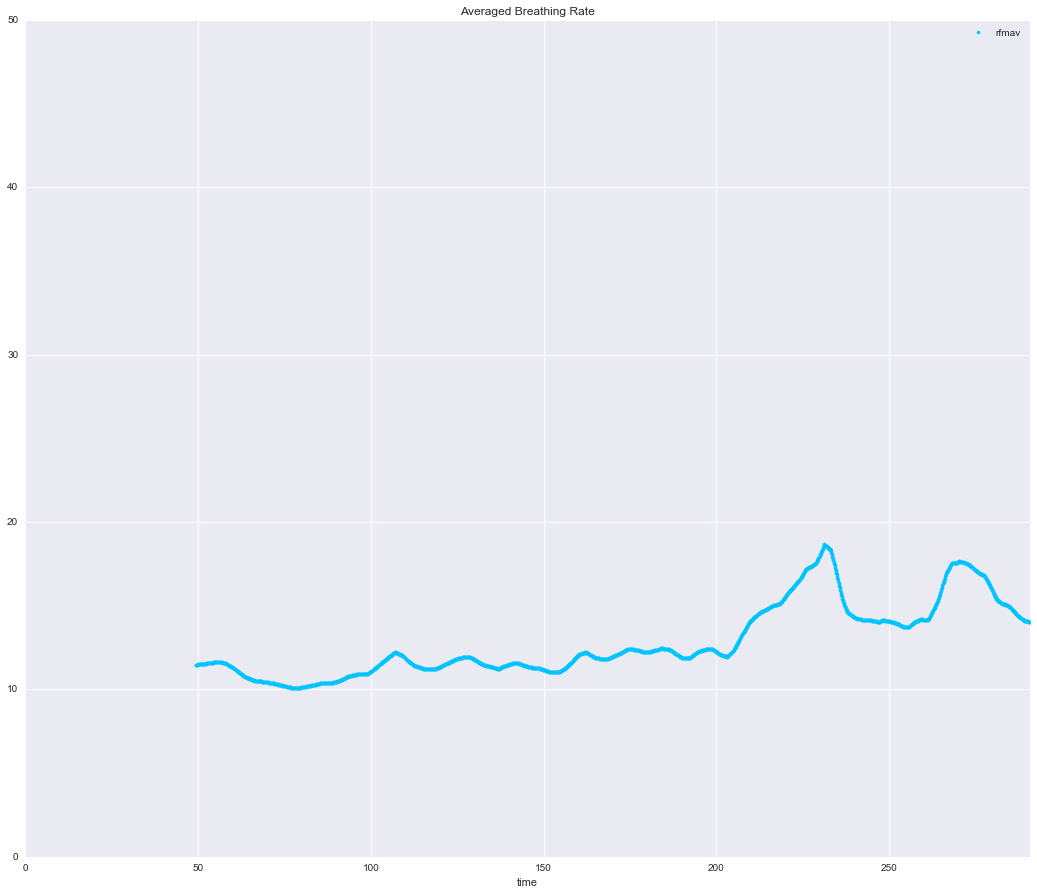

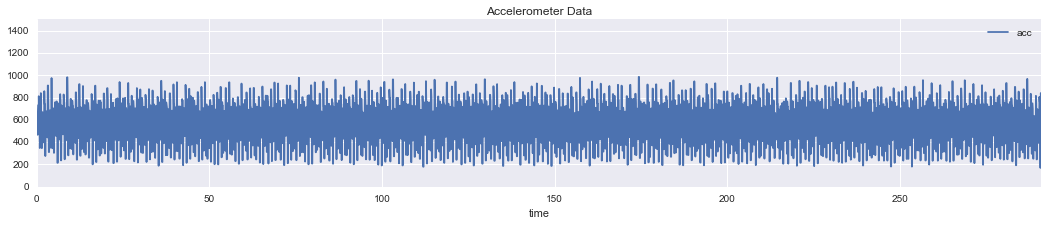

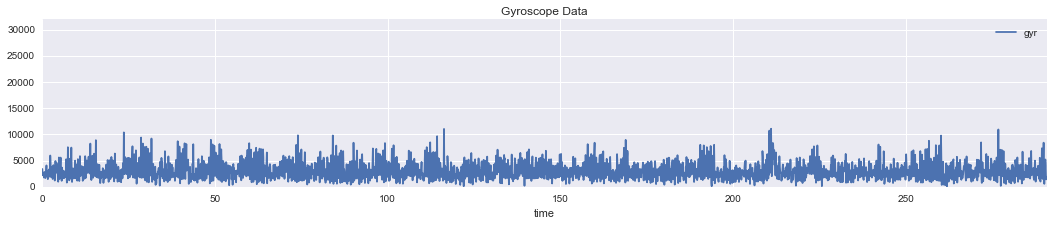

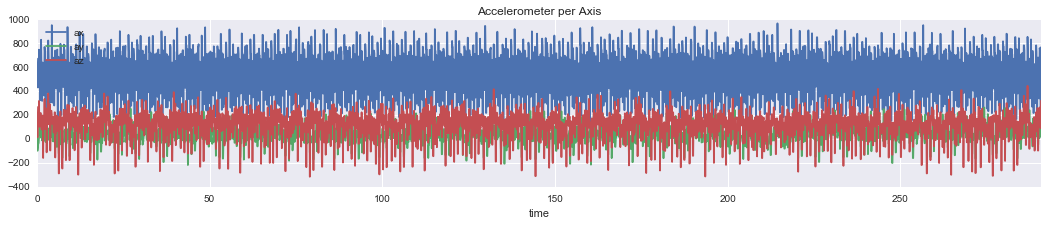

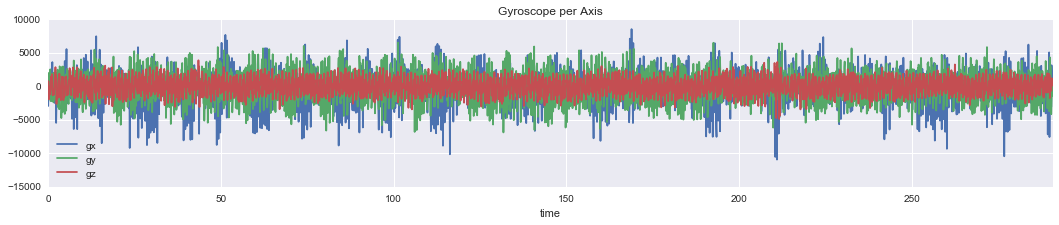

In [7]:
# this is just for plotting data 
g = d
g['cesm'] = f['cesm'] - 500
g['cmav'] = f['cmav'] - 500
g['del'] = f['del'] + 1900
g['b1'] = 1900
g['ph1'] = 100*f['ph1'] + 2800
#g['b2'] = 1600
#g['ph2'] = 100*f['ph2'] + 2200
#g.plot(x = 'time',y = ['chest','belly','cesm','cmav','del','b1','ph1','b2'],figsize = (18,15),title = 'Chest Data Processing')
g.plot(style=['-'],x = 'time',y = ['del'],figsize = (18,15), ylim = (1600,2200), title = 'Chest Data Processing')
#g.plot(x = 'time',y = ['chest','belly','ph1','ph2'],figsize = (18,15),title = 'Breathing Raw Data')
#d.plot(x = 'time',y = ['rlast','flast'], figsize = (18,3), title = 'Length of last detected breath, based on successive rise (r) and fall (f) times.')
d.plot(style=['.'], x = 'time',y = ['rfmav'], color = '#00C4FF', ylim = (0,50), figsize = (18,15), title = 'Averaged Breathing Rate')
d.plot(x = 'time',y = 'acc',figsize = (18,3), ylim=(0,1500), title = 'Accelerometer Data')
d.plot(x = 'time',y = 'gyr',figsize = (18,3), ylim=(0,32000), title = 'Gyroscope Data')
d.plot(x = 'time',y = ['ax','ay','az'],figsize = (18,3), title = 'Accelerometer per Axis')
d.plot(x = 'time',y = ['gx','gy','gz'],figsize = (18,3), title = 'Gyroscope per Axis')

Note that all moving averages are calculated using only data available at the time, which causes the corresponding curves to lag behind (compare moving averages of breath times to real-time breath times above). 

In [8]:
print(d[::1000]) # every thousandth line of the processed dataset

      index  chest  belly   ax   ay   az    gx    gy    gz   time  ...   \
0         0   2872      0  672  112  268 -2927 -1554   768    0.0  ...    
1000   1000   2902      0  736   87  294   231  1271  1367  100.0  ...    
2000   2000   2801      0  851   19   76  1077 -1956 -1939  200.0  ...    

                                             rbtime  \
0                                             [nan]   
1000  [7.7, 5.7, 5.9, 5.7, 4.1, 6.3, 5.8, 5.5, 2.5]   
2000  [2.5, 5.9, 4.7, 7.6, 4.8, 3.3, 4.3, 4.1, 7.7]   

                                             fbtime  rlast  flast       rmav  \
0                                             [nan]    NaN    NaN        NaN   
1000  [6.0, 7.3, 5.5, 5.9, 4.9, 5.1, 5.8, 5.8, 4.3]    2.5    4.3  11.027385   
2000  [6.2, 4.6, 6.0, 5.8, 4.1, 4.4, 4.0, 5.1, 5.1]    7.7    5.1  12.306009   

           fmav      rfmav         acc          gyr    b1  
0           NaN        NaN  732.087426  3401.774390  1900  
1000  11.104942  11.066163  797.30859

In [9]:
d.head(6000)

,index,chest,belly,ax,ay,az,gx,gy,gz,time,...,rbtime,fbtime,rlast,flast,rmav,fmav,rfmav,acc,gyr,b1
0,0,2872,0,672,112,268,-2927,-1554,768,0.0,...,[nan],[nan],NaN,NaN,NaN,NaN,NaN,732.087426,3401.774390,1900
1,1,2874,0,611,-98,15,1348,1636,734,0.1,...,[nan],[nan],NaN,NaN,NaN,NaN,NaN,618.991115,2243.291332,1900
2,2,2874,0,611,-98,15,-939,1605,-1924,0.2,...,[nan],[nan],NaN,NaN,NaN,NaN,NaN,618.991115,2675.728312,1900
3,3,2887,0,430,-73,163,-619,2048,-40,0.3,...,[nan],[nan],NaN,NaN,NaN,NaN,NaN,465.615721,2139.874996,1900
4,4,2888,0,439,-33,188,762,-1793,-1074,0.4,...,[nan],[nan],NaN,NaN,NaN,NaN,NaN,478.700324,2224.627834,1900
5,5,2886,0,439,-33,188,1099,-576,-1239,0.5,...,[nan],[nan],NaN,NaN,NaN,NaN,NaN,478.700324,1753.481679,1900
6,6,2859,0,747,16,318,959,2539,-848,0.6,...,[nan],[nan],NaN,NaN,NaN,NaN,NaN,812.027709,2843.467250,1900
7,7,2865,0,639,134,103,122,-2199,-473,0.7,...,[nan],[nan],NaN,NaN,NaN,NaN,NaN,660.973524,2252.601607,1900
8,8,2880,0,639,134,103,876,-1322,1457,0.8,...,[nan],[nan],NaN,NaN,NaN,NaN,NaN,660.973524,2153.580507,1900
9,9,2877,0,324,38,119,753,922,1161,0.9,...,[nan],[nan],NaN,NaN,NaN,NaN,NaN,347.247750,1662.833125,1900
